<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Parameters" data-toc-modified-id="Parameters-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Parameters</a></span></li><li><span><a href="#Load-data" data-toc-modified-id="Load-data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Load data</a></span><ul class="toc-item"><li><span><a href="#Cell-meta" data-toc-modified-id="Cell-meta-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Cell meta</a></span></li><li><span><a href="#Gene-meta" data-toc-modified-id="Gene-meta-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Gene meta</a></span></li><li><span><a href="#MCDS" data-toc-modified-id="MCDS-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>MCDS</a></span></li><li><span><a href="#adata" data-toc-modified-id="adata-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>adata</a></span></li></ul></li><li><span><a href="#Scale" data-toc-modified-id="Scale-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Scale</a></span></li><li><span><a href="#PCA" data-toc-modified-id="PCA-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>PCA</a></span><ul class="toc-item"><li><span><a href="#Concatenate-PC" data-toc-modified-id="Concatenate-PC-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Concatenate PC</a></span></li></ul></li><li><span><a href="#KNN" data-toc-modified-id="KNN-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>KNN</a></span></li><li><span><a href="#Clustering" data-toc-modified-id="Clustering-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Clustering</a></span></li><li><span><a href="#Calcluate-Coords" data-toc-modified-id="Calcluate-Coords-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Calcluate Coords</a></span></li><li><span><a href="#Get-cell-tidy-data" data-toc-modified-id="Get-cell-tidy-data-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Get cell tidy data</a></span></li><li><span><a href="#Plot-basic-matrics" data-toc-modified-id="Plot-basic-matrics-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Plot basic matrics</a></span></li><li><span><a href="#Calculate-mCH-marker" data-toc-modified-id="Calculate-mCH-marker-10"><span class="toc-item-num">10&nbsp;&nbsp;</span>Calculate mCH marker</a></span></li></ul></div>

In [1]:
from dask.distributed import Client
client = Client(dashboard_address=':46064')

In [2]:
import configparser
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy.api as sc
import seaborn as sns
import xarray as xr
import warnings
import anndata
from cemba_data.local.mc.prepare_study import prepare_study
from cemba_data.plot import *
from cemba_data.plot.preprocessing import *
from cemba_data.tools.hdf5.anndata import highly_variable_methylation_feature
from ALLCools.mcds.MCDS import MCDS
from cemba_data.tools.hdf5.anndata import rank_features_groups

# Per Region Coords and Cluster

In [3]:
result_dir = pathlib.Path()
result_dir.mkdir(exist_ok=True)
fig_dir = result_dir / 'fig'
fig_dir.mkdir(exist_ok=True)

## Parameters

In [4]:
project_dir = '/home/hanliu/project/mouse_rostral_brain/'

cell_meta_path = '/home/hanliu/project/mouse_rostral_brain/study/regional_qc/cell_meta.after_qc.msg'
gene_annotation_path = '/home/hanliu/ref/mouse/gencode/vm22/gencode.vM22.annotation.gene.flat.tsv.gz'

clustering_feature = 'chrom100k'  # 100kb chromosome bins

# preprocess parameters
min_feature_cov, max_feature_cov = 500, 3000

ch_hvf_top = 3000
min_ch_hvf_mean = 0.5
max_ch_hvf_mean = 2.5

cg_hvf_top = 3000
min_cg_hvf_mean = 0.5
max_cg_hvf_mean = 1.2

ch_pc_components = 25
cg_pc_components = 14

n_neighbors = 25
resolution = 0.8

mch_gene_score_cutoff = 5
mch_abs_log_fold_change = 1
n_marker_genes = 500

In [5]:
# Parameters
regions = ["1A", "1B", "1C", "2A", "2B", "2C", "2D", "2E", "3A", "3B", "3C", "3D", "3E", "3F", "4A", "4B", "4C", "4D", "4E", "4F", "4G", "4H", "5A", "5B", "5C", "5D", "5E", "5F", "5G", "5H", "5J", "6A", "6B", "6C", "6D", "7B", "8B", "9H", "9J", "11E", "11F"]

In [6]:
project_dir = pathlib.Path(project_dir)

## Load data
### Cell meta

In [7]:
cell_meta = pd.read_msgpack(result_dir / 'used_cells.msg')
cell_meta.shape

(100449, 23)

### Gene meta

In [8]:
gene_meta = pd.read_csv(gene_annotation_path, index_col='gene_id', sep='\t')
gene_meta.index.name = 'gene'
gene_name_to_id = {v:k for k, v in gene_meta['gene_name'].iteritems()}
gene_id_base_to_id = pd.Series(gene_meta.index, index = gene_meta.index.map(lambda i: i.split('.')[0])).to_dict()

### MCDS

In [9]:
# mcds_path
dataset_dir = project_dir / 'dataset'
mcds_path_list = [i for i in dataset_dir.glob('*mcds') if i.name.split('-')[0] in regions]

In [10]:
mcds = MCDS.open(mcds_path_list, 
                 use_cells=cell_meta[cell_meta['PassFilter']].index,
                 combine='nested', concat_dim='cell').chunk({'cell': 500})

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


/home/hanliu/miniconda3/envs/clustering/lib/python3.7/site-packages/xarray/core/indexing.py:1201: PerformanceWarning: Slicing with an out-of-order index is generating 126 times more chunks
  return self.array[key]


### adata

In [10]:
ch_adata = anndata.read_h5ad('mch_adata.norm_per_cell.hvf.h5ad')

In [11]:
cg_adata = anndata.read_h5ad('mcg_adata.norm_per_cell.hvf.h5ad')

## Scale

In [12]:
sc.pp.scale(ch_adata)
sc.pp.scale(cg_adata)

## PCA

In [13]:
ch_adata.obs['Region'] = cell_meta['Region'].reindex(ch_adata.obs_names).astype(str)

... storing 'Region' as categorical


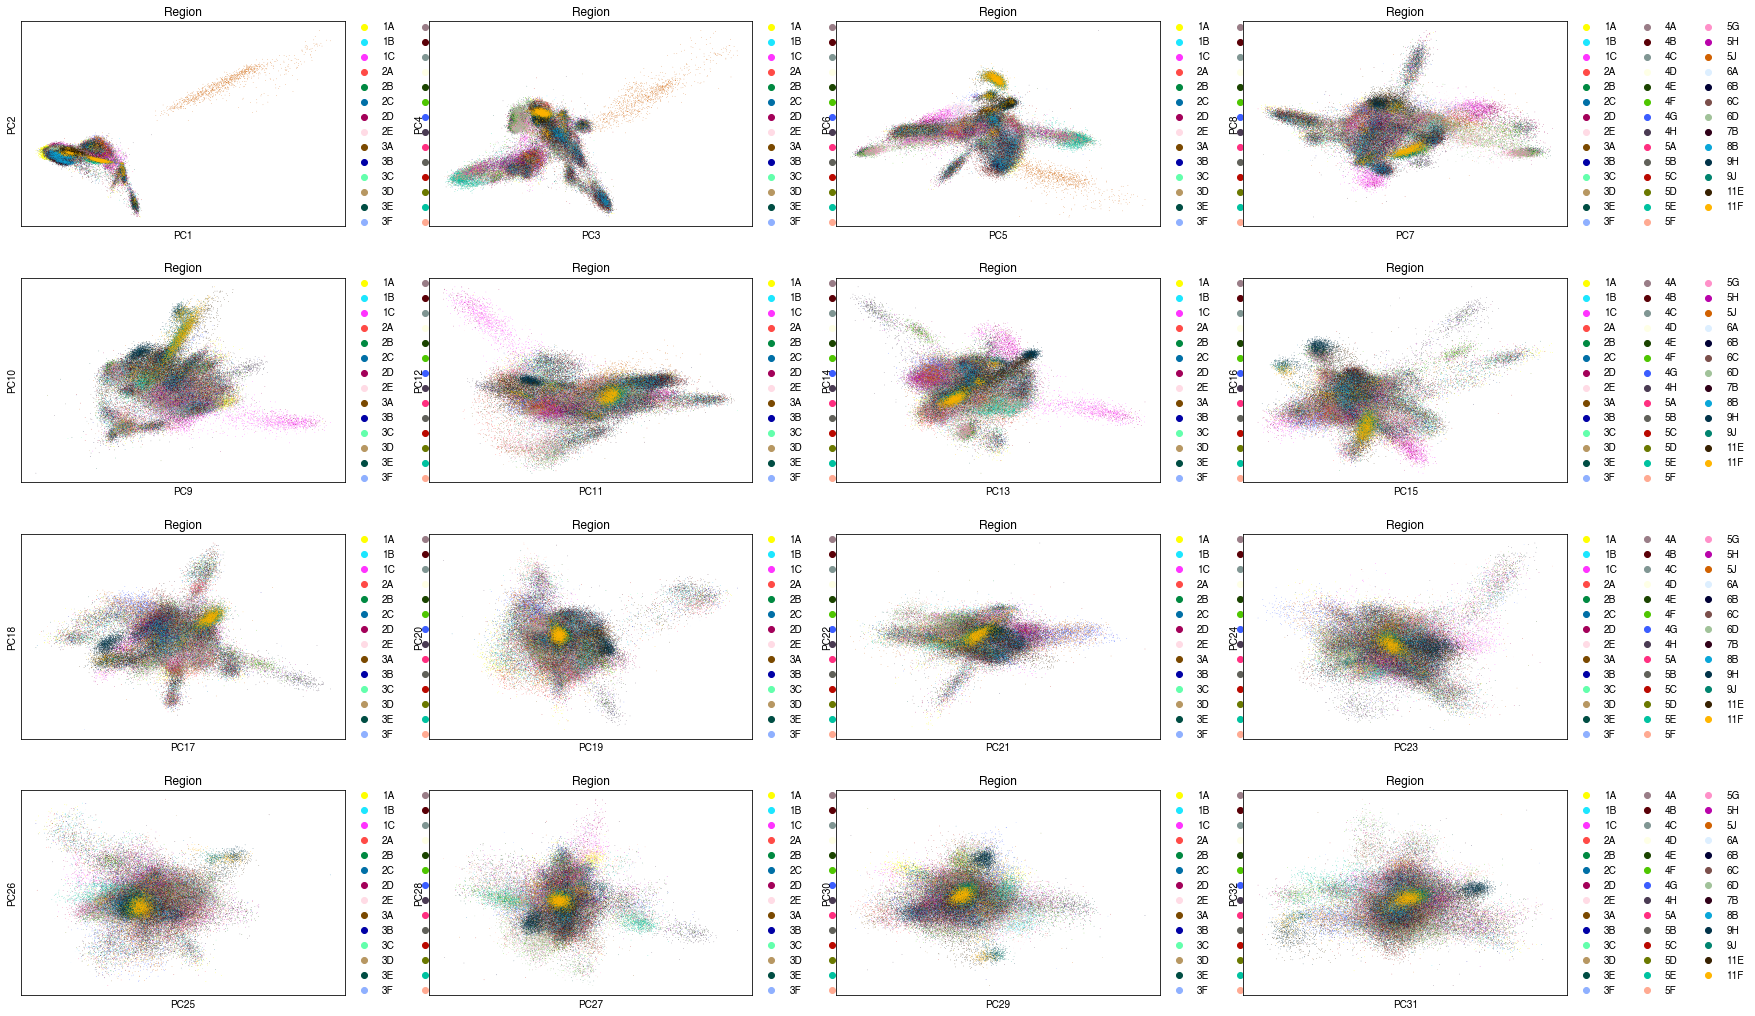

In [14]:
sc.tl.pca(ch_adata, n_comps=50)
sc.pl.pca(ch_adata, components=['1,2', '3,4', '5,6','7,8', 
                                '9,10', '11,12','13,14', '15,16', 
                                '17,18', '19,20', '21,22', '23,24', 
                                '25,26', '27,28', '29,30', '31,32'], 
          color='Region')

In [15]:
cg_adata.obs['Region'] = cell_meta['Region'].reindex(cg_adata.obs_names).astype(str)

... storing 'Region' as categorical


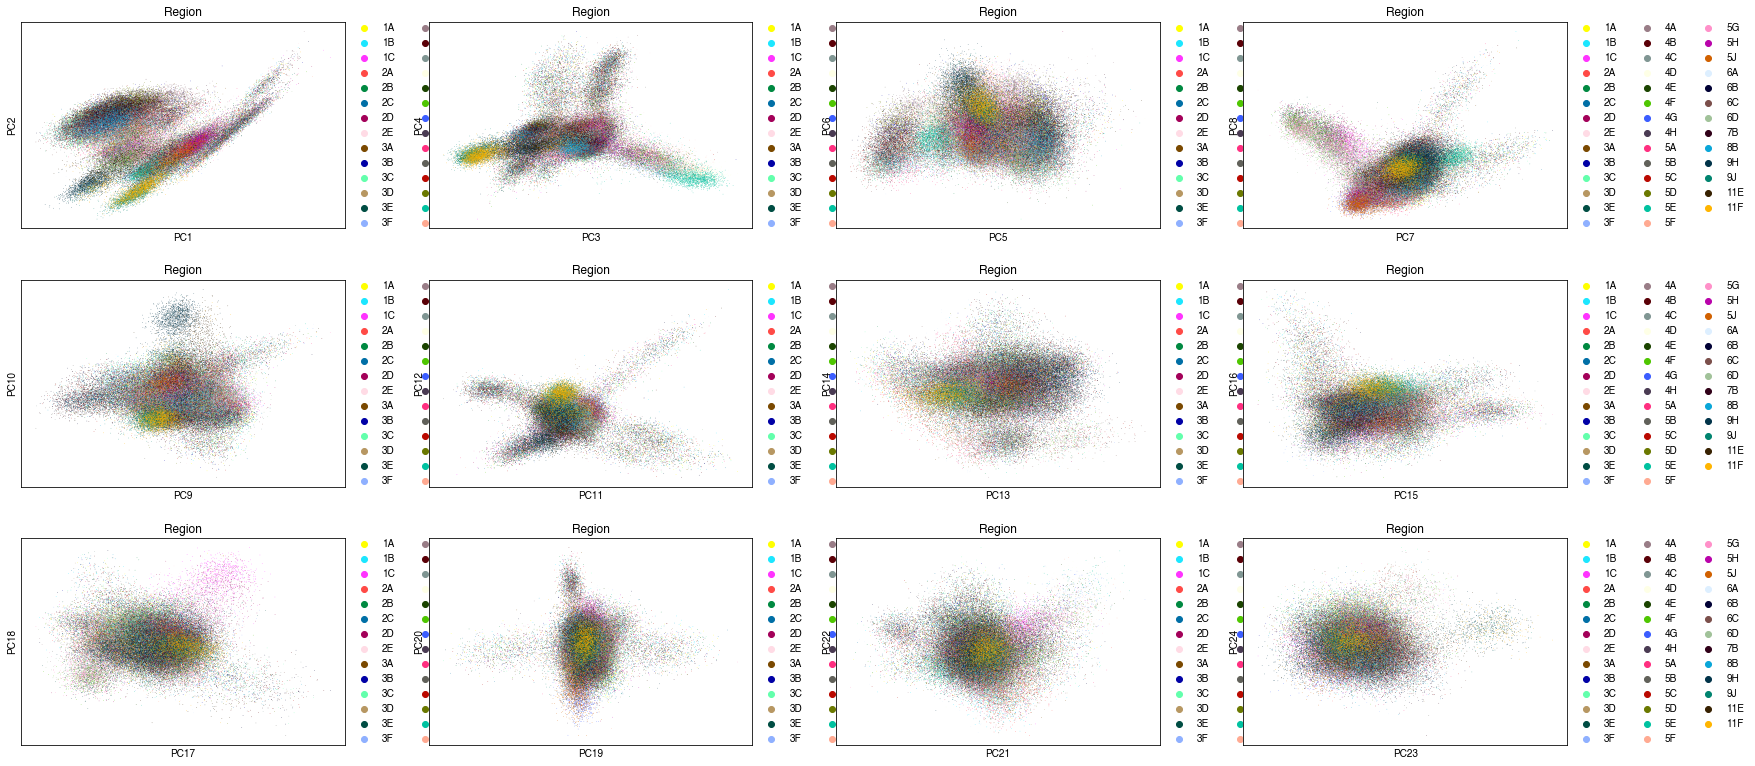

In [16]:
sc.tl.pca(cg_adata, n_comps=50)
sc.pl.pca(cg_adata, components=['1,2', '3,4', '5,6','7,8', 
                                '9,10', '11,12','13,14', '15,16',
                                '17,18', '19,20', '21,22', '23,24'],
          color='Region')

### Concatenate PC

In [17]:
total_pca = np.concatenate([ch_adata.obsm['X_pca'][:, :ch_pc_components], 
                            cg_adata.obsm['X_pca'][:, :cg_pc_components]], 
                           axis=1)
adata = ch_adata.copy()
adata.obsm['X_pca'] = total_pca

## KNN

In [18]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    sc.pp.neighbors(adata, n_neighbors=n_neighbors)

## Clustering

In [19]:
sc.tl.leiden(adata, resolution=resolution)

## Calcluate Coords

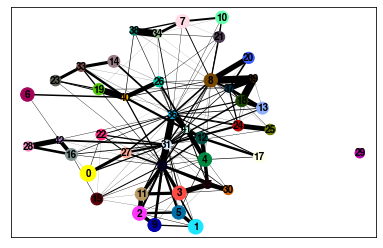

In [20]:
sc.tl.paga(adata, groups='leiden')
sc.pl.paga(adata)
sc.tl.umap(adata, init_pos='paga')
sc.tl.tsne(adata, n_jobs=45, perplexity=120)

## Get cell tidy data

In [21]:
coords_dfs = [cell_meta]
for coords in ['pca', 'umap', 'tsne']:
    coords_df = pd.DataFrame(adata.obsm[f'X_{coords}'][:, :2], 
                             index=adata.obs_names,
                             columns=[f'{coords}_{i}' for i in range(2)])
    coords_dfs.append(coords_df)
cell_tidy_data = pd.concat(coords_dfs, axis=1, sort=True)
cell_tidy_data['leiden'] = adata.obs['leiden'].apply(lambda i: f'c{int(i):02d}')
cell_tidy_data.to_msgpack(result_dir / 'cell_coords_and_clusters.msg')

## Plot basic matrics

In [22]:
coords = 'umap'

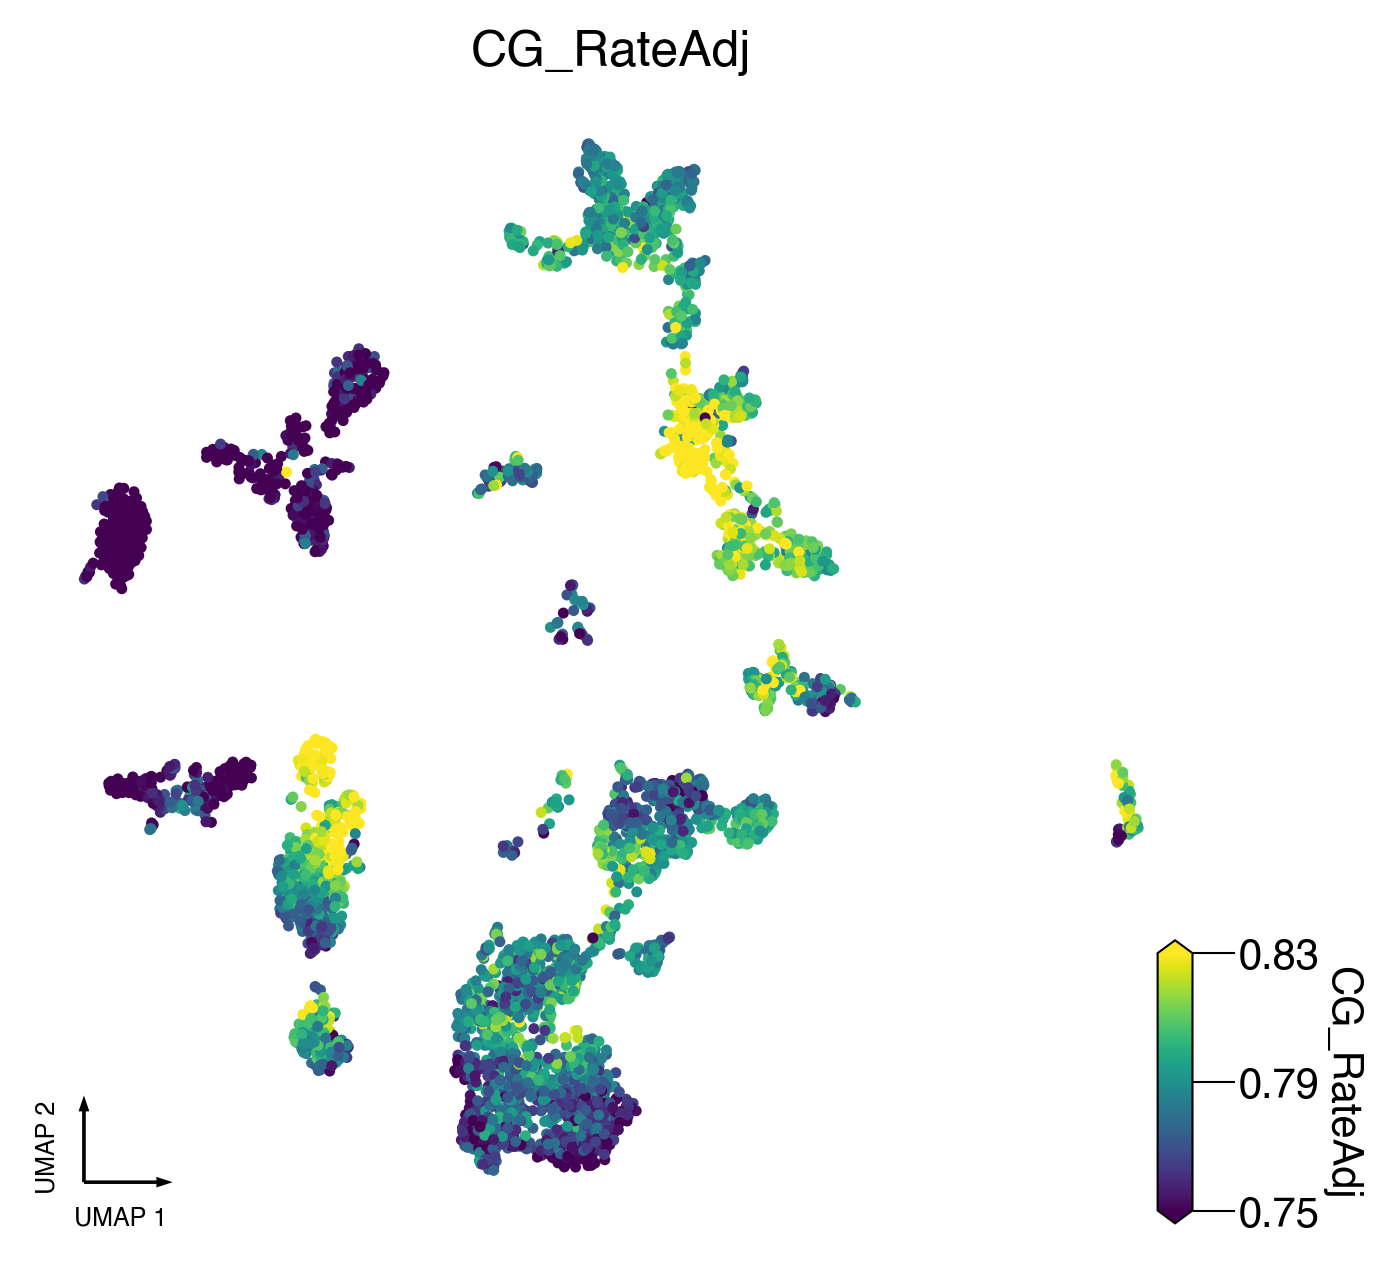

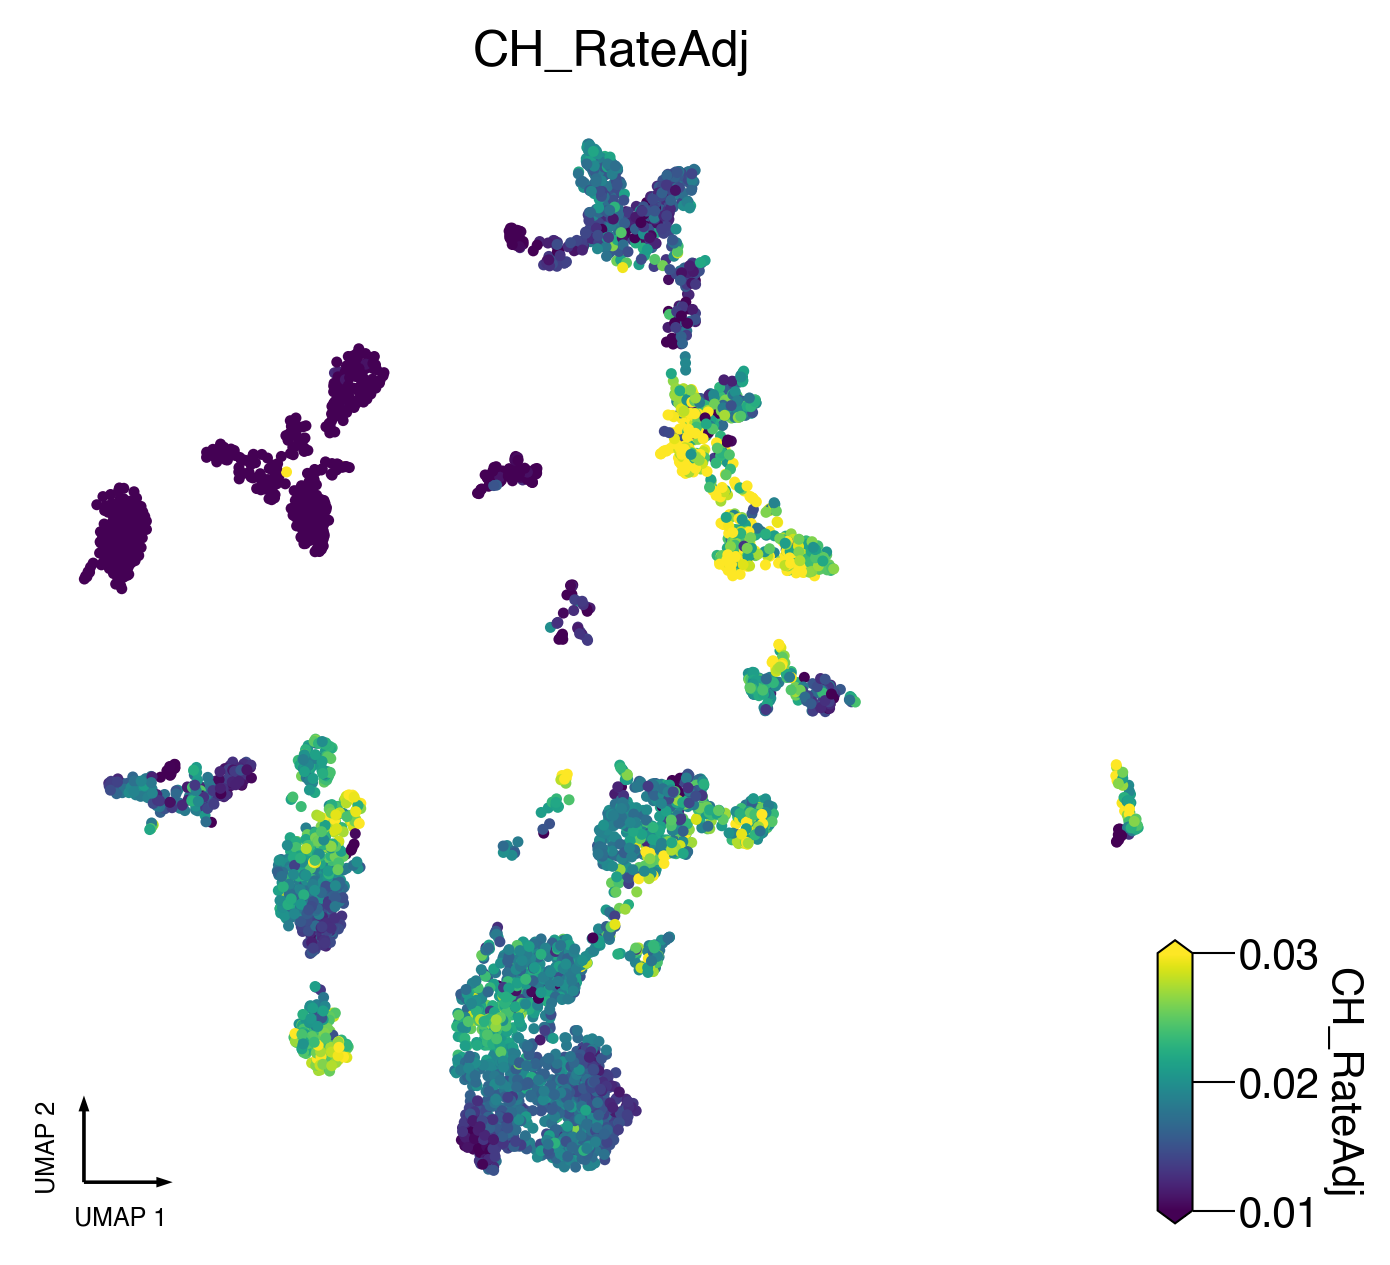

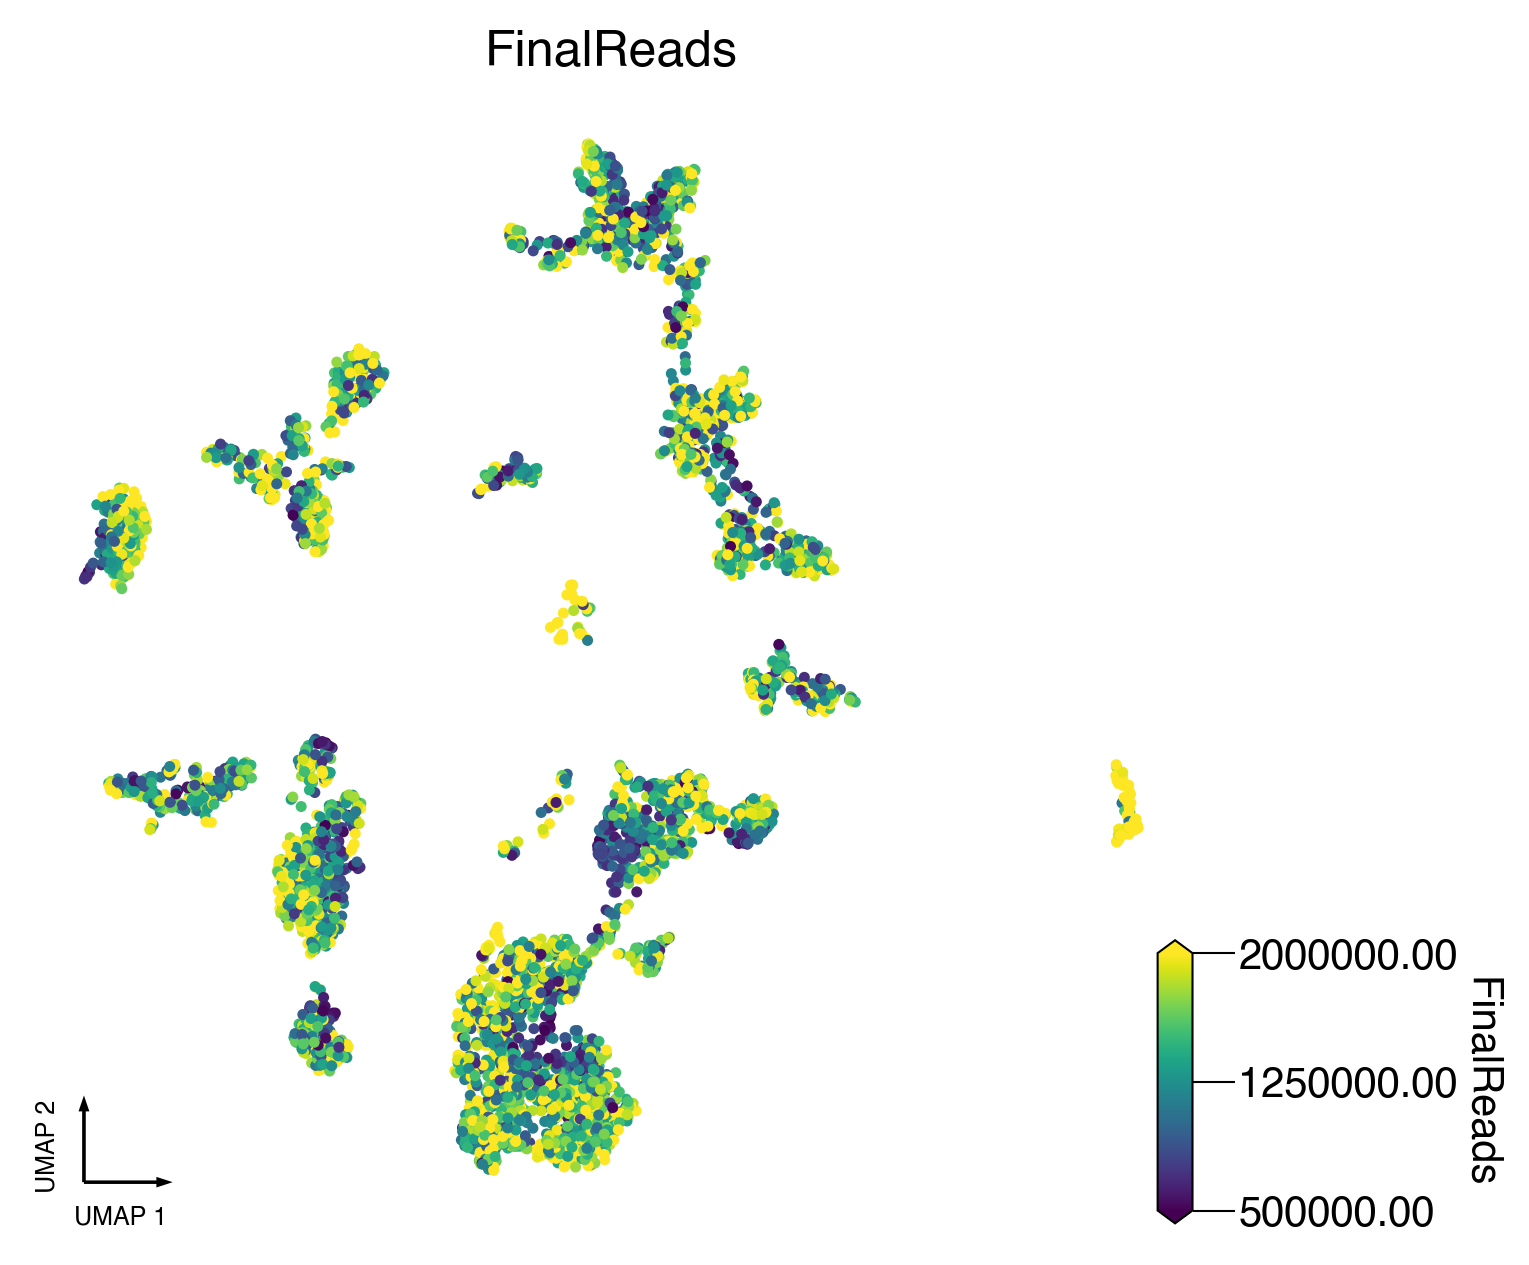

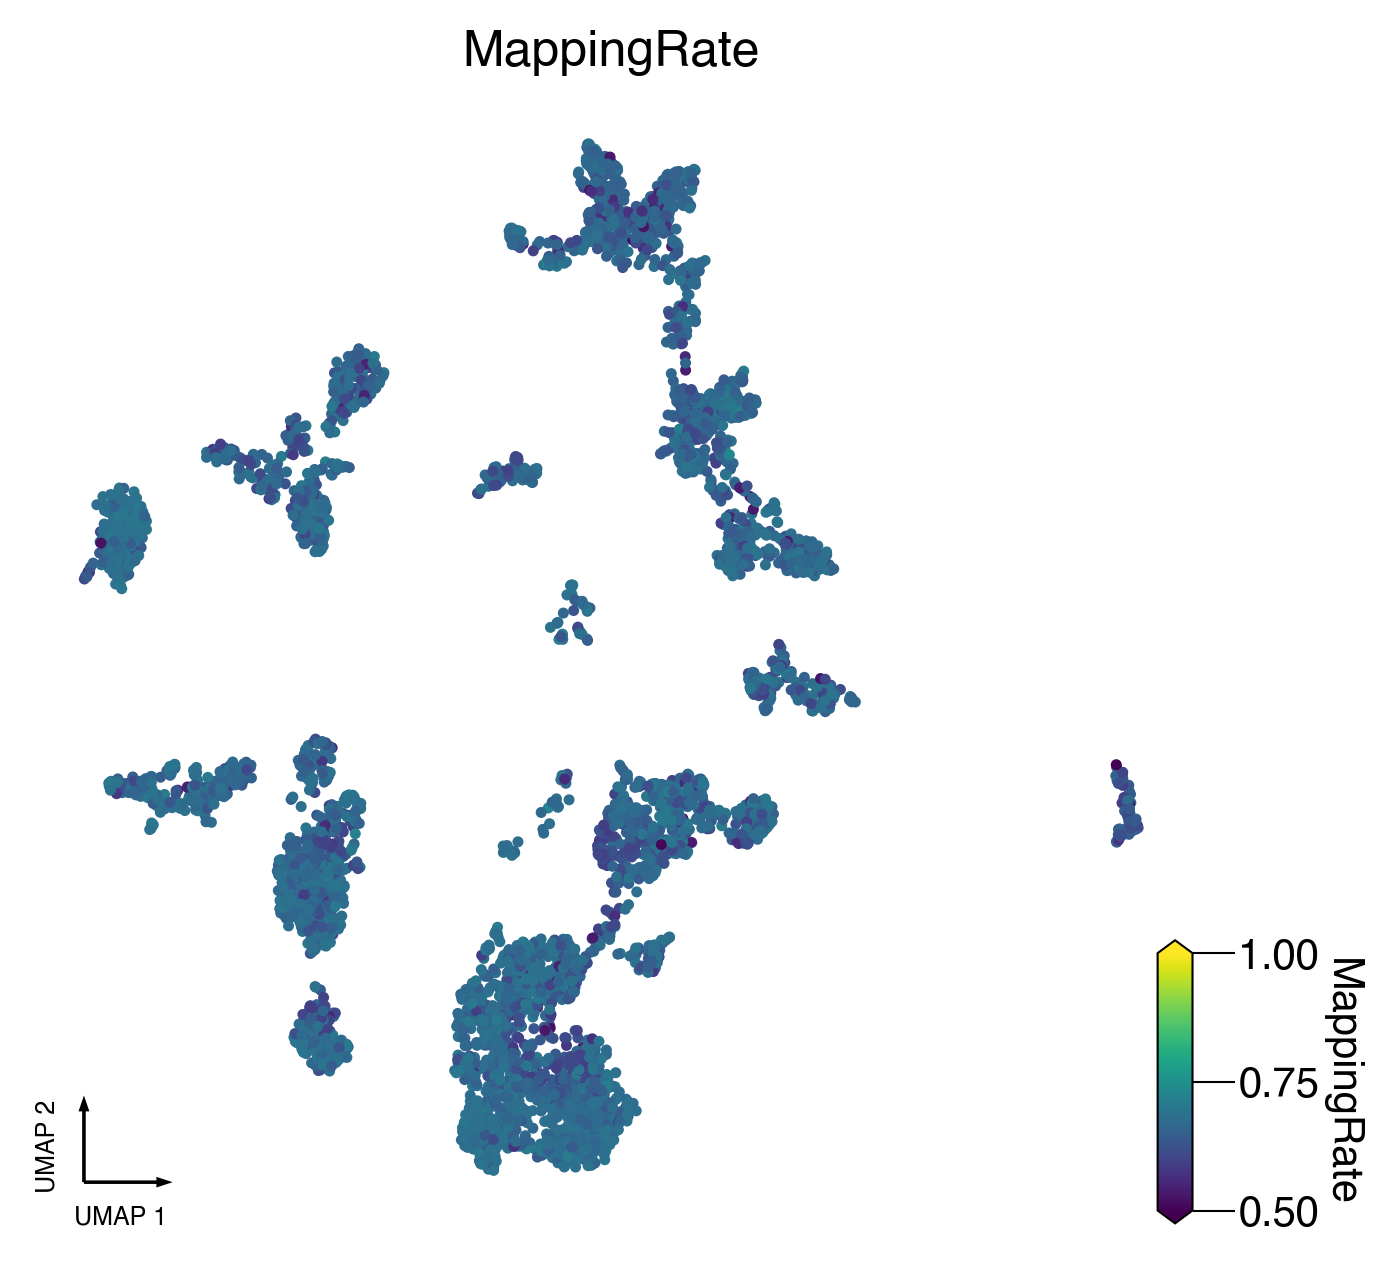

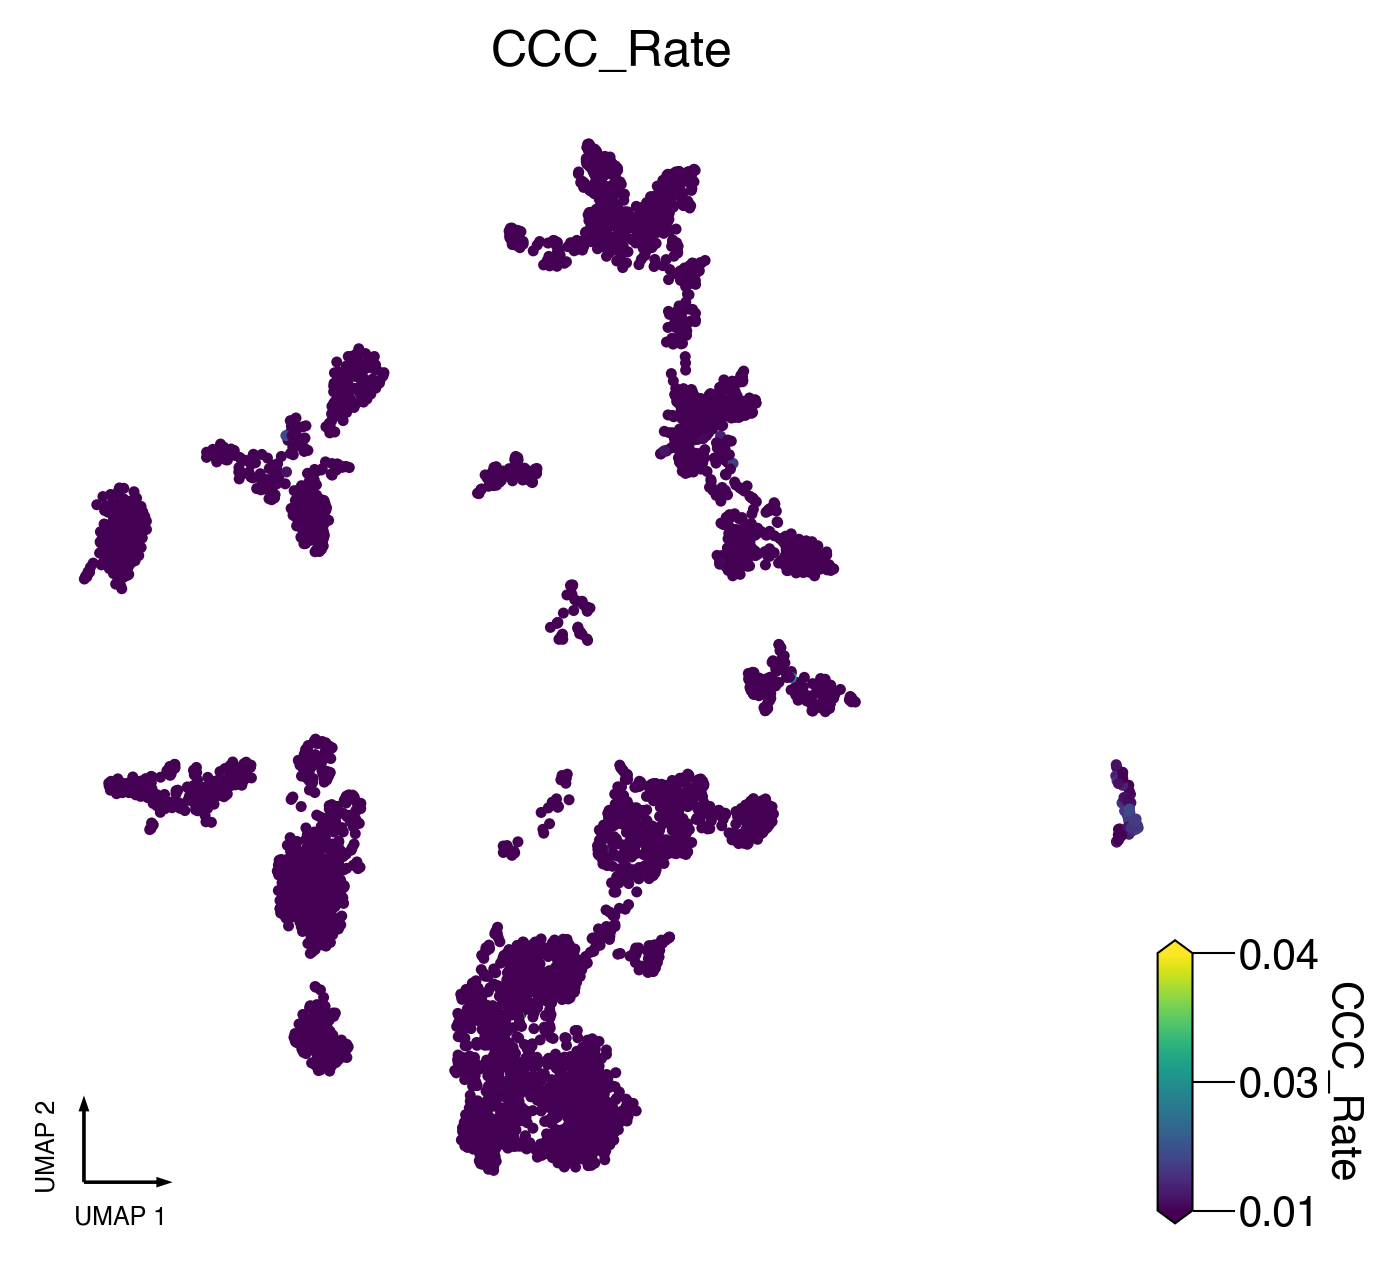

In [23]:
hues = ['CG_RateAdj', 'CH_RateAdj', 'FinalReads', 'MappingRate', 'CCC_Rate']
hue_norms = [None, None, (500000, 2000000), (0.5, 1), (0.01, 0.04)]

for hue, hue_norm in zip(hues, hue_norms):
    fig, ax = plt.subplots(figsize=(5, 5), dpi=300)
    (ax, cax), _ = continuous_scatter(cell_tidy_data, ax, coord_base=coords, 
                                      hue=hue, hue_norm=hue_norm)
    ax.set_title(hue)
    fig.savefig(fig_dir / f'{coords}.{hue}.pdf')

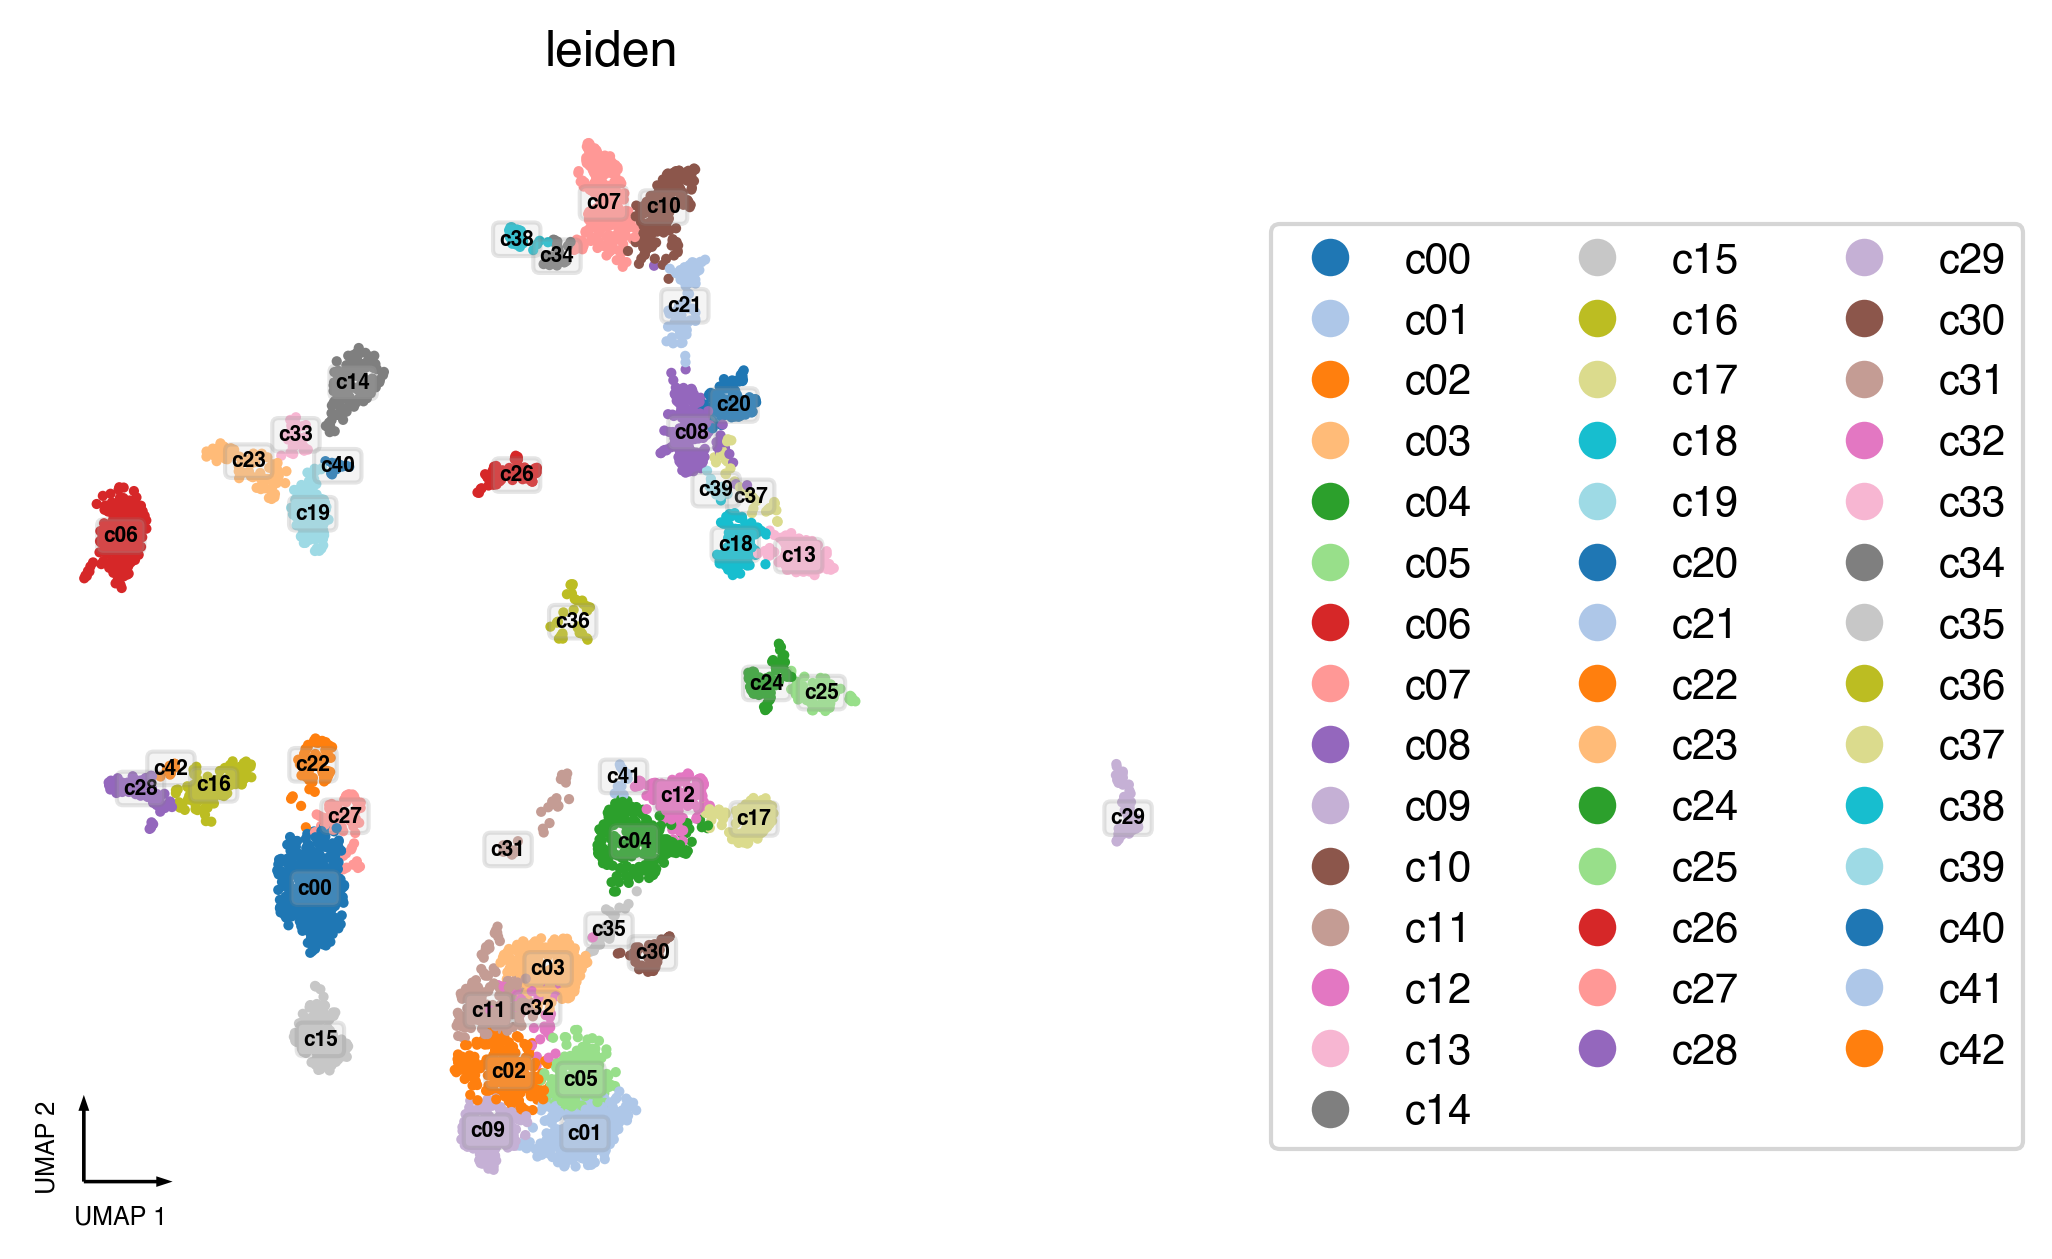

In [24]:
fig, ax = plt.subplots(figsize=(5, 5), dpi=300)
categorical_scatter(cell_tidy_data, 
                    ax, 
                    coord_base=coords, 
                    hue='leiden',
                    text_anno='leiden',
                    palette='tab20',
                    show_legend=True,
                    scatter_kws=dict(s=6),
                    text_anno_kws=dict(fontsize=5),
                    legend_kws=dict(bbox_to_anchor=(1.05, 0.9)))
ax.set_title('leiden')
fig.savefig(fig_dir / f'{coords}.leiden.pdf')

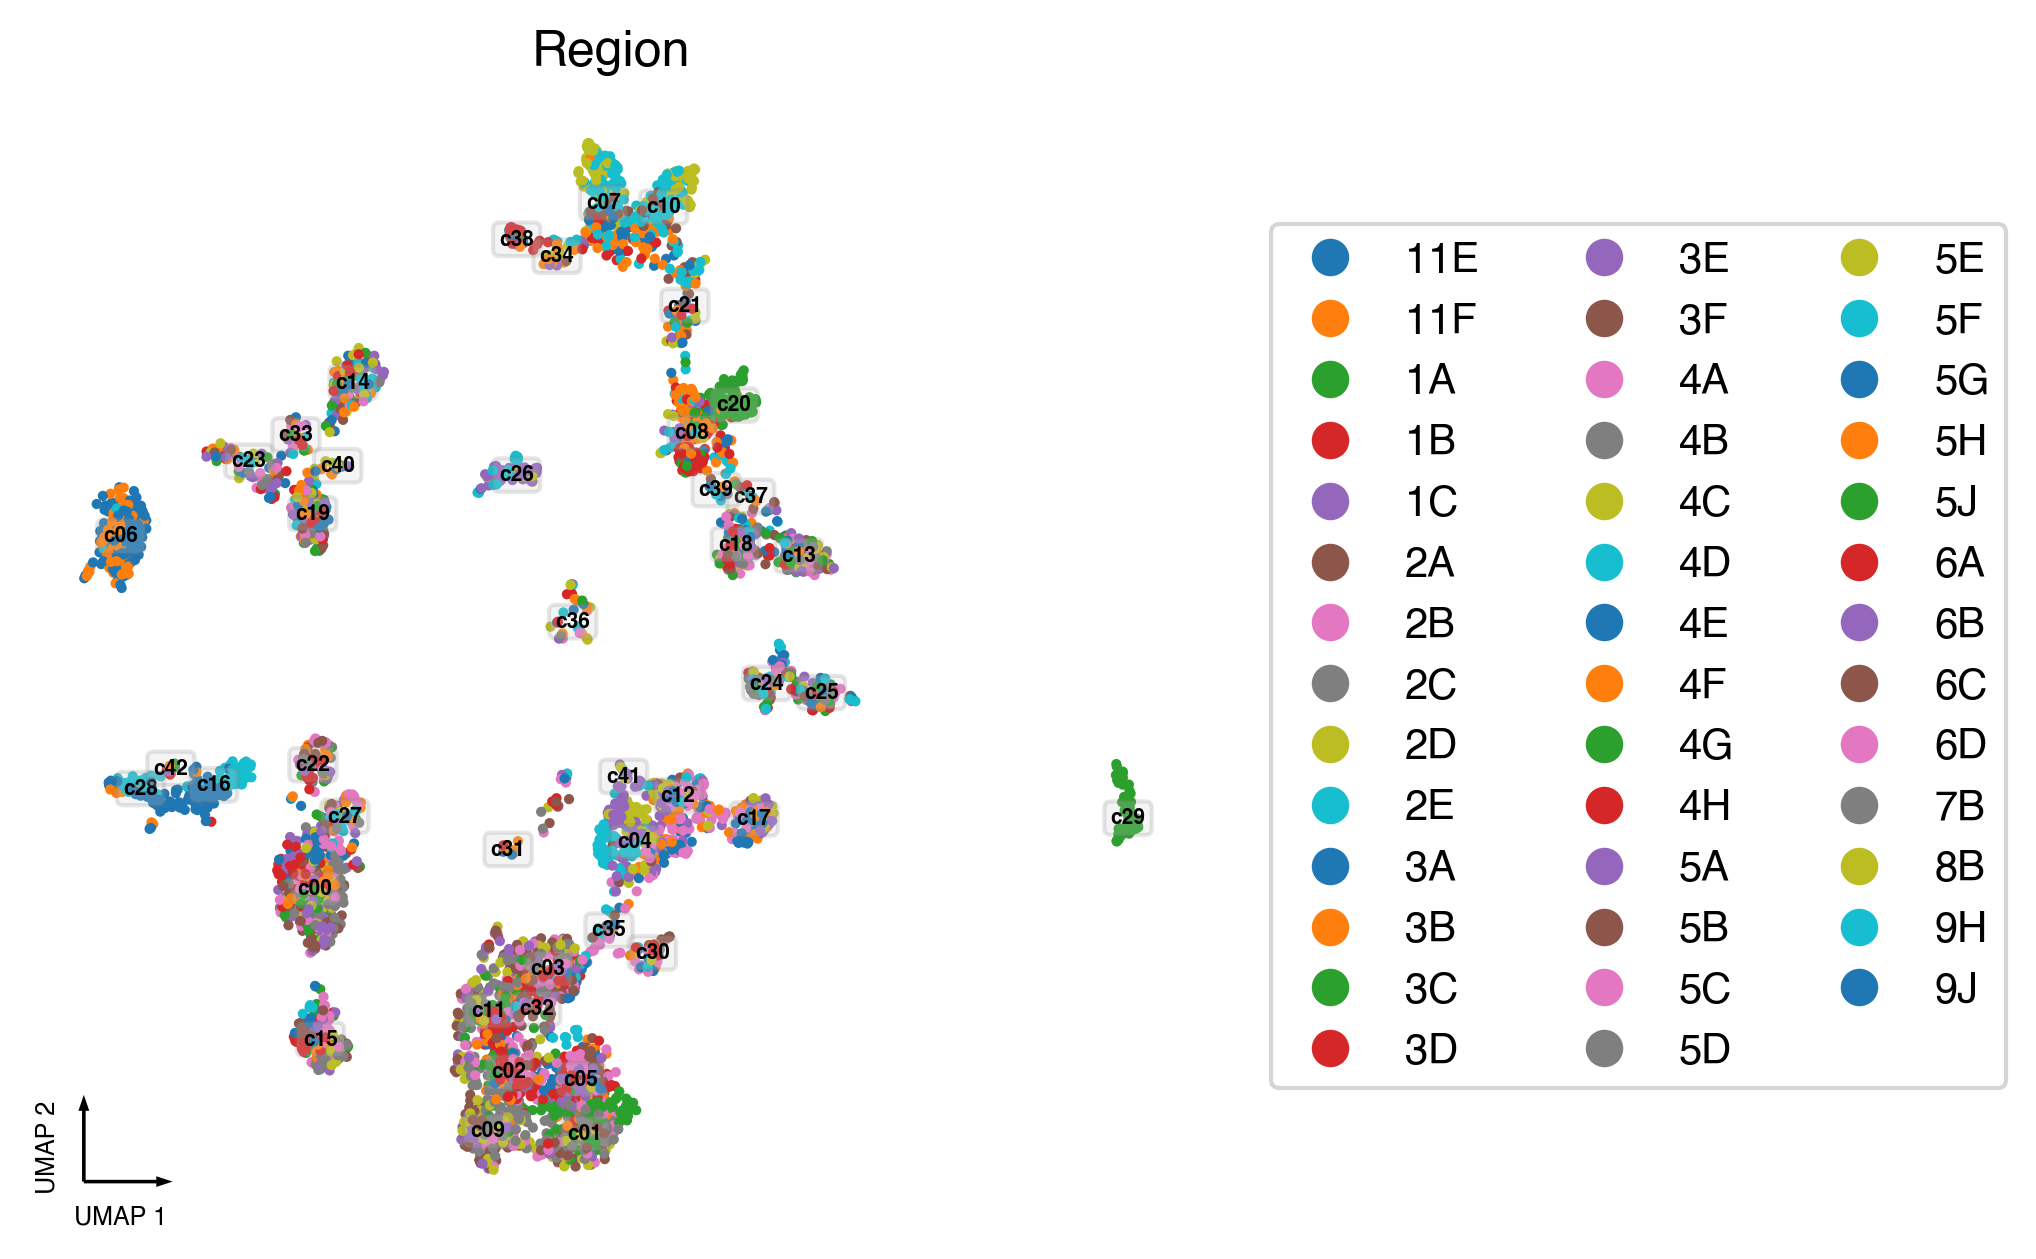

In [25]:
fig, ax = plt.subplots(figsize=(5, 5), dpi=300)
categorical_scatter(cell_tidy_data, 
                    ax, 
                    coord_base=coords, 
                    hue='Region',
                    text_anno='leiden',
                    palette='tab10',
                    show_legend=True,
                    scatter_kws=dict(s=6),
                    text_anno_kws=dict(fontsize=5),
                    legend_kws=dict(bbox_to_anchor=(1.05, 0.9)))
ax.set_title('Region')
fig.savefig(fig_dir / f'{coords}.Region.pdf')

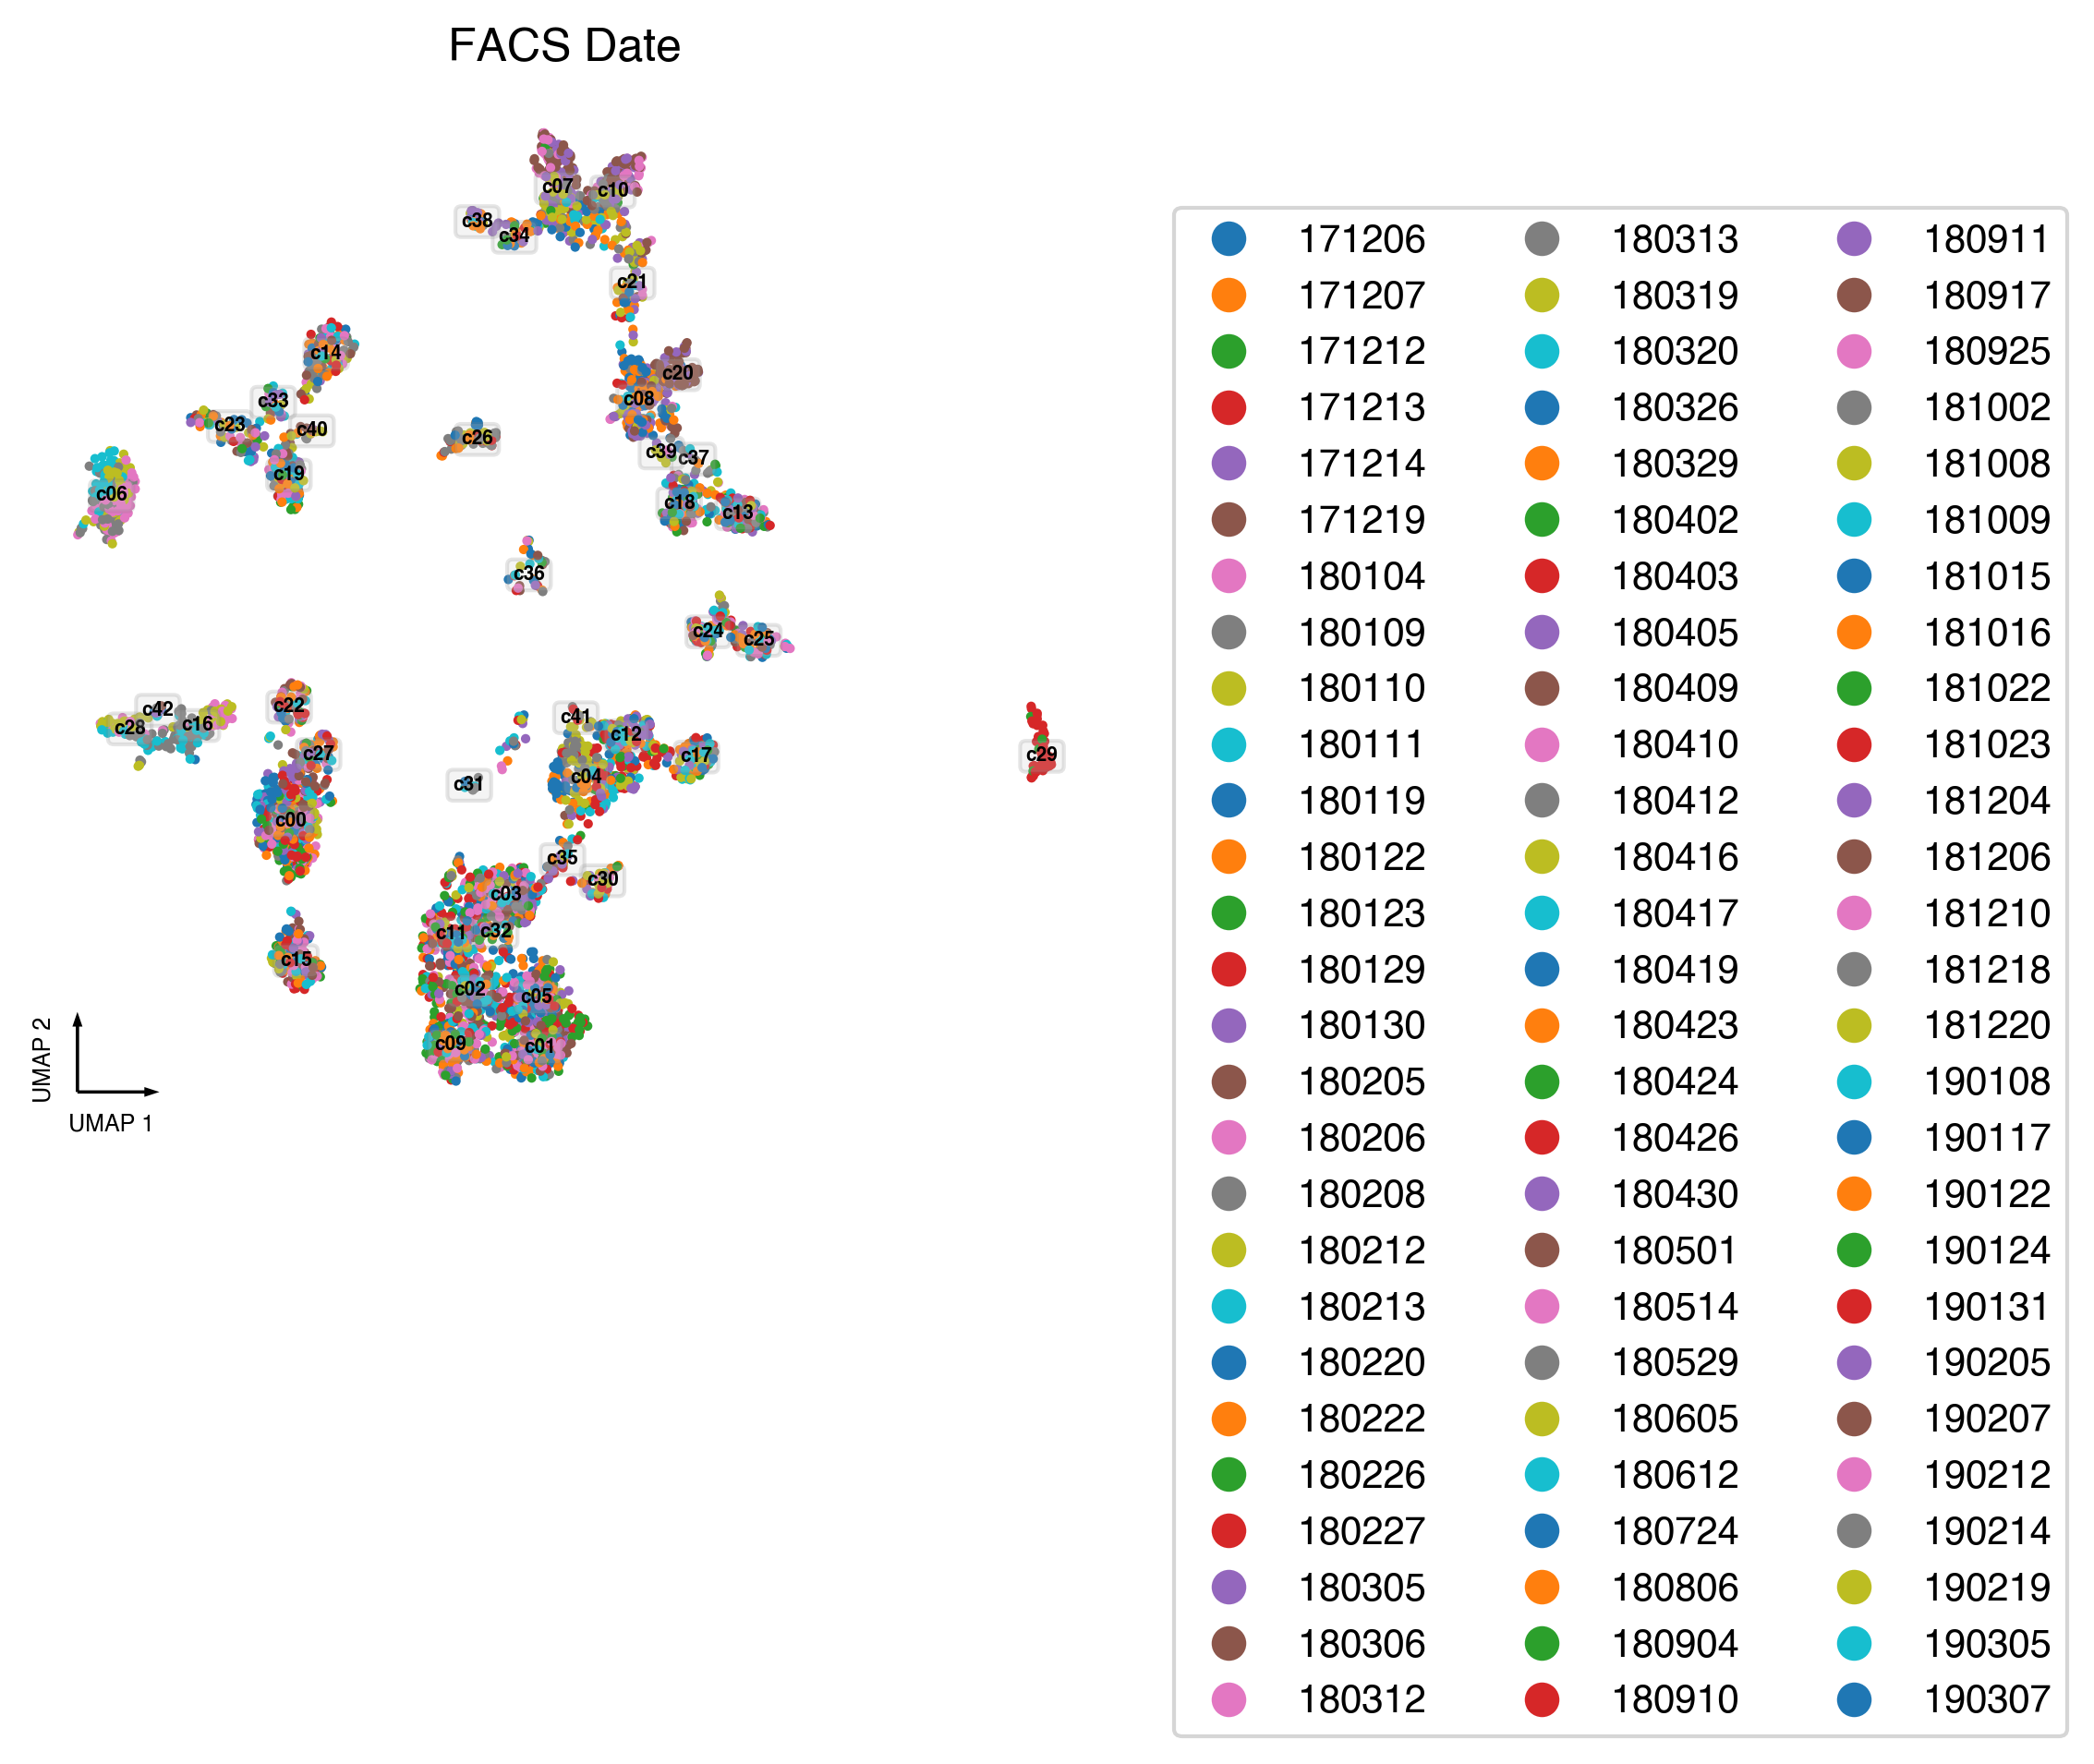

In [26]:
fig, ax = plt.subplots(figsize=(5, 5), dpi=300)
categorical_scatter(cell_tidy_data, 
                    ax, 
                    coord_base=coords, 
                    hue='FACS_Date',
                    text_anno='leiden',
                    palette='tab10',
                    show_legend=True,
                    scatter_kws=dict(s=6),
                    text_anno_kws=dict(fontsize=5),
                    legend_kws=dict(bbox_to_anchor=(1.05, 0.9)))
ax.set_title('FACS Date')
fig.savefig(fig_dir / f'{coords}.FACS_Date.pdf')

## Calculate mCH marker

In [10]:
small_cell_meta = cell_meta.sample(50000, random_state=1).sort_index()

In [15]:
cell_tidy_data = pd.read_msgpack(result_dir / 'cell_coords_and_clusters.msg')

In [13]:
gene_da = xr.open_mfdataset('gene_rate*gene_da_rate*mcds', 
                  combine='nested', 
                  concat_dim='cell')['gene_da'].sel(cell=small_cell_meta.index, mc_type='CHN')

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [16]:
ch_gene_adata = anndata.AnnData(X=gene_da.values, 
                                obs=pd.DataFrame([], index=gene_da.get_index('cell')),
                                var=pd.DataFrame([], index=gene_da.get_index('gene')))
ch_gene_adata.obs['cluster'] = cell_tidy_data['leiden'].astype('category')


In [17]:
rank_features_groups(adata=ch_gene_adata, 
                     groupby='cluster',
                     groups='all',
                     reference='rest',
                     n_genes=n_marker_genes,
                     rankby_abs=False,
                     copy=False,
                     corr_method='benjamini-hochberg')

name_df = pd.DataFrame(ch_gene_adata.uns['rank_genes_groups']['names'])
score_df = pd.DataFrame(ch_gene_adata.uns['rank_genes_groups']['scores'])
fold_change_df = pd.DataFrame(ch_gene_adata.uns['rank_genes_groups']['logfoldchanges'])

filter_df = pd.DataFrame({'score': score_df.unstack(),
                          'log_fold_change': fold_change_df.unstack(),
                          'name': name_df.unstack()})
filter_df['judge'] = (filter_df['score'] > mch_gene_score_cutoff) & \
                     (filter_df['log_fold_change'].abs() > mch_abs_log_fold_change)

selected_ch_features = filter_df[filter_df['judge']]['name'].unique()
selected_ch_features = np.unique(np.concatenate([name_df.iloc[:30, :].values.ravel(), selected_ch_features]))

name_df.to_msgpack(result_dir / 'mCH_marker_name.msg')
score_df.to_msgpack(result_dir / 'mCH_marker_test_score.msg')
fold_change_df.to_msgpack(result_dir / 'mCH_marker_fold_change.msg')
with open(result_dir / 'mCH_selected_feature.txt', 'w') as f:
    for feature in selected_ch_features:
        f.write(feature + '\n')

/home/hanliu/miniconda3/envs/clustering/lib/python3.7/site-packages/cemba_data/tools/hdf5/anndata.py:320: RuntimeWarning: invalid value encountered in sqrt
  denominator = np.sqrt(vars[igroup] / ns_group + var_rest / ns_rest)


         Falling back to preprocessing with `sc.pp.pca` and default params.


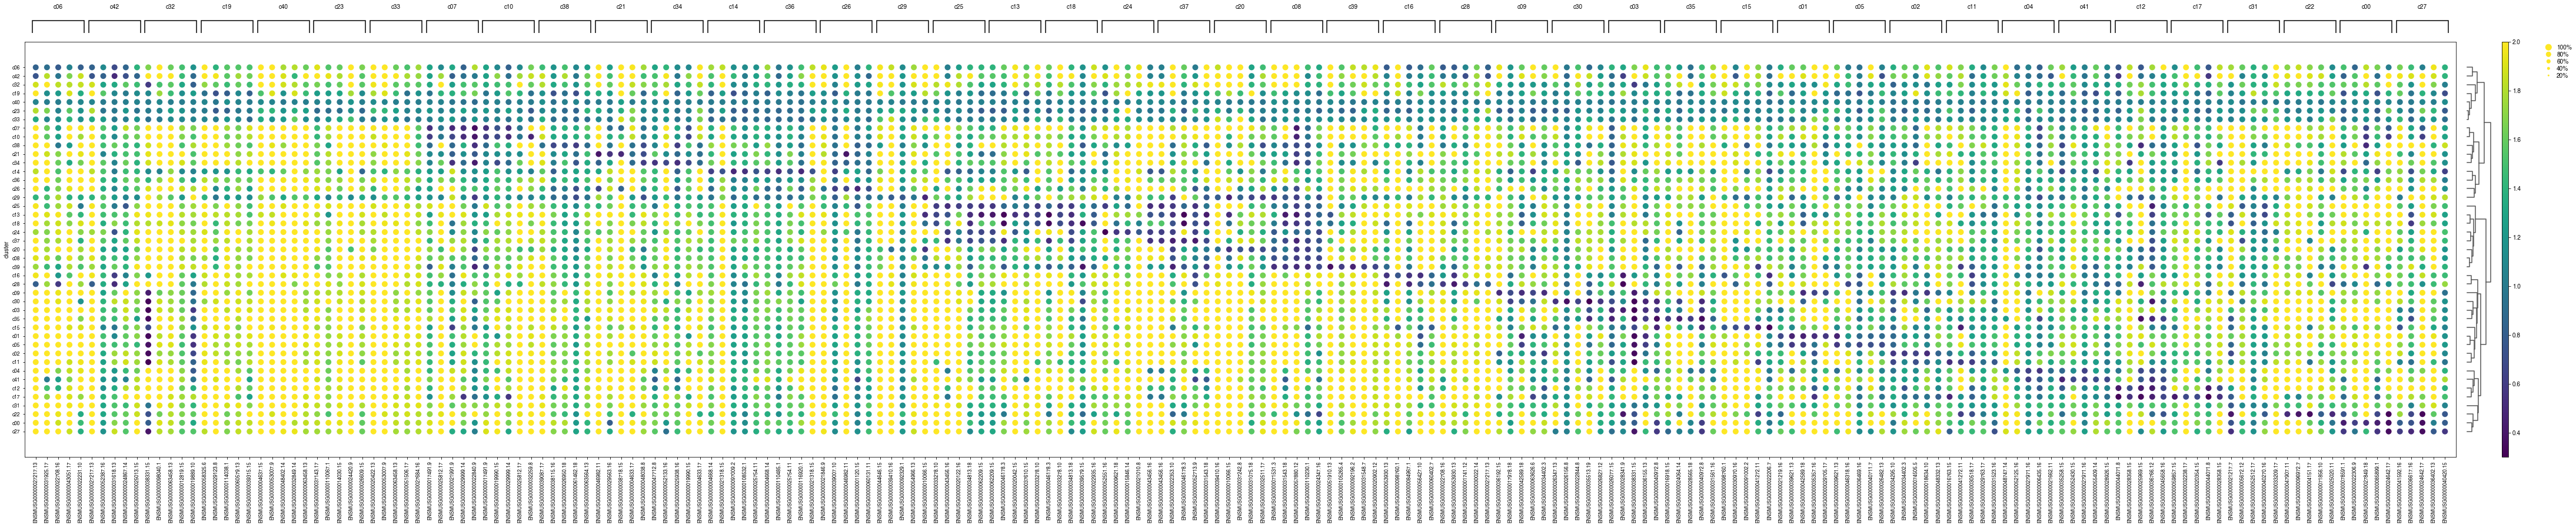

In [18]:
sc.pl.rank_genes_groups_dotplot(ch_gene_adata, 
                                vmin=0.3, 
                                vmax=2, 
                                n_genes=5, 
                                color_map='viridis')